In [17]:
#### config.py ####
import os

# Model file paths
MODEL_PATHS = {
    "vehicle": r"F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intelligent_Traffic_Violation_detection_and_Explanation_System\Code\Models\yolov8n.pt",
    "number_plate": r"F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intelligent_Traffic_Violation_detection_and_Explanation_System\Code\Models\license_plate_detector2\weights\best.pt",
    "helmet": r"F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intelligent_Traffic_Violation_detection_and_Explanation_System\Code\Models\helmet_model9\weights\best.pt",
    "lane": r"F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intelligent_Traffic_Violation_detection_and_Explanation_System\Code\Models\lane_model18\weights\best.pt",
    "red_light": r"F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intelligent_Traffic_Violation_detection_and_Explanation_System\Code\Models\red_light_model7\weights\best.pt",
    "white_line": r"F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intelligent_Traffic_Violation_detection_and_Explanation_System\Code\Models\lane_model18\weights\best.pt"
}

# Image and output folders
IMAGE_FOLDER = r"F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intelligent_Traffic_Violation_detection_and_Explanation_System\Code\test_images"
OUTPUT_FOLDER = r"F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intelligent_Traffic_Violation_detection_and_Explanation_System\Code\ocr_results"

# Create output folder if not exists
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

# Default location value
DEFAULT_LOCATION = "Test Location"

# Database configuration
DB_CONFIG = {
    "host": "localhost",
    "user": "root",
    "password": "sangwan2003",
    "database": "traffic_violation_db"
}


In [18]:

####detect_plate###



from ultralytics import YOLO
import cv2
import numpy as np

_model_cache = {}

def _load_model(key):
    if key in _model_cache:
        return _model_cache[key]
    path = MODEL_PATHS.get(key)
    if not path:
        raise ValueError(f"Model path for {key} not set in config.py")
    try:
        model = YOLO(path)
    except Exception as e:
        raise RuntimeError(f"Failed to load model {key} at {path}: {str(e)}")
    _model_cache[key] = model
    return model

def detect_vehicles(image, conf=0.35):
    model = _load_model("vehicle")
    res = model(image)[0]
    detections = []
    if hasattr(res, "boxes") and len(res.boxes) > 0:
        boxes = res.boxes.xyxy.cpu().numpy()
        confs = res.boxes.conf.cpu().numpy()
        clss = res.boxes.cls.cpu().numpy()
        for box, c, cls_id in zip(boxes, confs, clss):
            if c < conf:
                continue
            x1, y1, x2, y2 = map(int, box)
            cls_name = res.names[int(cls_id)] if hasattr(res, "names") else str(int(cls_id))
            detections.append({"bbox": [x1, y1, x2, y2], "cls": cls_name, "conf": float(c)})
    return detections

def detect_plate_boxes(cropped_vehicle_image, conf=0.2):
    model = _load_model("number_plate")
    res = model(cropped_vehicle_image)[0]
    plates = []
    if hasattr(res, "boxes") and len(res.boxes) > 0:
        boxes = res.boxes.xyxy.cpu().numpy()
        confs = res.boxes.conf.cpu().numpy()
        for box, c in zip(boxes, confs):
            if c < conf:
                continue
            x1, y1, x2, y2 = map(int, box)
            plates.append({"bbox": [x1, y1, x2, y2], "conf": float(c)})
    return plates


In [19]:
###preprocess_plate###


import cv2
import numpy as np

def preprocess_plate(plate_img, scale=2):
    """
    Preprocess a cropped license plate image for OCR.
    
    Args:
        plate_img (np.array): BGR crop of plate.
        scale (int): Scaling factor to enlarge plate for better OCR.
        
    Returns:
        thresh (np.array): Preprocessed binary image for OCR.
    """
    if plate_img is None or plate_img.size == 0:
        return None

    # Convert to grayscale
    gray = cv2.cvtColor(plate_img, cv2.COLOR_BGR2GRAY)

    h, w = gray.shape

    # Enlarge image proportionally
    fx = max(1, int(scale * (400 / max(h, w))))
    gray = cv2.resize(gray, None, fx=fx, fy=fx, interpolation=cv2.INTER_CUBIC)

    # Denoise using bilateral filter
    gray = cv2.bilateralFilter(gray, 9, 75, 75)

    # Adaptive thresholding
    try:
        thresh = cv2.adaptiveThreshold(
            gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            cv2.THRESH_BINARY, 11, 2
        )
    except Exception:
        _, thresh = cv2.threshold(
            gray, 0, 255,
            cv2.THRESH_BINARY + cv2.THRESH_OTSU
        )

    return thresh


In [20]:
###ocr_extract###


import easyocr

# Confidence threshold for OCR
OCR_CONF_THRESHOLD = 0.4

# Create a single EasyOCR reader instance (English)
_reader = None
def _get_reader():
    global _reader
    if _reader is None:
        _reader = easyocr.Reader(['en'], gpu=False)  # set gpu=True if you have GPU
    return _reader

def extract_text_from_image(img, conf_threshold=OCR_CONF_THRESHOLD):
    """
    Extract text from an image crop using EasyOCR.

    Args:
        img (np.array): Grayscale or color image of plate.
        conf_threshold (float): Min confidence threshold.

    Returns:
        (text, confidence, engine_name): tuple
    """
    reader = _get_reader()
    try:
        results = reader.readtext(img)
    except Exception as e:
        print("OCR error:", e)
        return None, 0.0, None

    if not results:
        return None, 0.0, "easyocr"

    # Pick result with highest confidence
    best = max(results, key=lambda x: x[2])
    text = best[1].strip()
    conf = float(best[2])

    if conf < conf_threshold:
        return None, conf, "easyocr"

    return text, conf, "easyocr"


In [21]:
###post_process text###


import re

# tune this to your expected plate patterns (example Indian plates)
PLATE_REGEX = re.compile(r"[A-Z0-9]{4,20}")  # coarse pattern

def fix_confusions(s):
    """
    Fix common OCR misreadings for number plates.
    Example: O→0, I→1, L→1, B→8
    """
    if not s:
        return None
    s = s.upper()
    s = s.replace(" ", "").replace("-", "")
    s = s.replace("O", "0")
    s = s.replace("I", "1")
    s = s.replace("L", "1")
    s = s.replace("B", "8")
    return s

def clean_plate_text(raw_text, timestamp=None):
    """
    Cleans raw OCR text from a plate image.
    timestamp: optional (for video frame integration)
    Returns cleaned plate text or None.
    """
    if not raw_text:
        return None
    txt = fix_confusions(raw_text)
    m = PLATE_REGEX.search(txt)
    clean_text = m.group(0) if m else txt
    if timestamp is not None:
        return {"plate": clean_text, "timestamp": timestamp}
    return clean_text


In [22]:
###video_preprocessing###


import cv2
import os


def process_video(video_path, frame_skip=5, save_folder=None):
    """
    Process video to detect violations frame by frame.
    
    Args:
        video_path: path to video file
        frame_skip: process every N-th frame (for speed)
        save_folder: folder to save annotated frames/videos
    """
    if save_folder is None:
        save_folder = os.path.join(OUTPUT_FOLDER, "video_outputs")
    os.makedirs(save_folder, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    output_path = os.path.join(save_folder, "annotated_output.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % frame_skip == 0:
            timestamp_ms = int(cap.get(cv2.CAP_PROP_POS_MSEC))
            detections = detect_vehicles(frame)

            bboxes = []
            labels = []
            for det in detections:
                bbox = det["bbox"]
                cls_name = det["cls"]
                violations = detect_vehicle_violations(frame, bbox, cls_name, frame_timestamp=timestamp_ms, save_path=save_folder)

                bboxes.append(bbox)
                labels.append(", ".join(violations))

            draw_and_save(frame, bboxes, labels, os.path.join(save_folder, f"frame_{frame_idx}.jpg"))

        out_video.write(frame)
        frame_idx += 1

    cap.release()
    out_video.release()
    print(f"[INFO] Video processing complete. Annotated video saved to: {output_path}")


In [23]:
###database###


import mysql.connector
from mysql.connector import Error

from datetime import datetime

def init_db():
    try:
        conn = mysql.connector.connect(
            host=DB_CONFIG['host'],
            user=DB_CONFIG['user'],
            password=DB_CONFIG['password']
        )
        cursor = conn.cursor()
        cursor.execute(f"CREATE DATABASE IF NOT EXISTS {DB_CONFIG['database']}")
        conn.commit()
        cursor.close()
        conn.close()

        conn = mysql.connector.connect(**DB_CONFIG)
        cursor = conn.cursor()
        cursor.execute("""
            CREATE TABLE IF NOT EXISTS violation (
                id INT AUTO_INCREMENT PRIMARY KEY,
                plate_number VARCHAR(255),
                violation_type VARCHAR(255),
                location VARCHAR(255),
                image_path TEXT,
                detection_time TIMESTAMP DEFAULT CURRENT_TIMESTAMP,
                video_timestamp_ms BIGINT DEFAULT NULL
            )
        """)
        conn.commit()
        cursor.close()
        conn.close()
    except Error as e:
        print(f"Database init error: {e}")

def log_violation(plate_number, violation_type, location, image_path, video_timestamp_ms=None):
    try:
        conn = mysql.connector.connect(**DB_CONFIG)
        cursor = conn.cursor()
        sql = """
            INSERT INTO violation 
            (plate_number, violation_type, location, image_path, video_timestamp_ms) 
            VALUES (%s, %s, %s, %s, %s)
        """
        cursor.execute(sql, (plate_number, violation_type, location, image_path, video_timestamp_ms))
        conn.commit()
        cursor.close()
        conn.close()
    except Error as e:
        print(f"DB log error: {e}")


In [24]:
###visulaize###


import cv2
import os

def draw_and_save(image, bbox, text, out_path, color=(0, 255, 0)):
    """
    Draw bounding box with text label and save annotated image.

    Args:
        image (np.array): Image to annotate.
        bbox (list): Bounding box [x1, y1, x2, y2].
        text (str): Text label to display.
        out_path (str): Path to save annotated image.
        color (tuple): RGB color for bounding box.
    """
    x1, y1, x2, y2 = bbox
    cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
    label = text if text else "Unknown"
    y_text = y1 - 10 if y1 > 20 else y1 + 20
    cv2.putText(image, label, (x1, y_text), cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2, cv2.LINE_AA)

    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    cv2.imwrite(out_path, image)


In [25]:
###violation_detection###



import numpy as np
import cv2
import os

def detect_violation_by_model(crop, model_key, conf_thresh=0.4):
    model = _load_model(model_key)
    res = model(crop)[0]
    if hasattr(res, "boxes") and len(res.boxes) > 0:
        confs = res.boxes.conf.cpu().numpy()
        boxes = res.boxes.xyxy.cpu().numpy()
        filtered_boxes = [boxes[i] for i, c in enumerate(confs) if c > conf_thresh]
        if filtered_boxes:
            return filtered_boxes
    return None


def detect_helmet_violation(crop):
    """
    Detect helmets directly on the vehicle crop.
    Returns True if no helmets detected (violation).
    """
    helmet_boxes = detect_violation_by_model(crop, "helmet", conf_thresh=0.35)

    # If no helmets found at all → violation
    if not helmet_boxes:
        return True

    return False



def detect_lane_violation(full_image, vehicle_bbox):
    x1, y1, x2, y2 = vehicle_bbox
    crop = full_image[y1:y2, x1:x2]
    lane_boxes = detect_violation_by_model(crop, "lane", conf_thresh=0.35)
    return bool(lane_boxes)


def detect_white_line_violation(full_image, vehicle_bbox):
    white_line_boxes = detect_violation_by_model(full_image, "lane", conf_thresh=0.35)  # using lane model
    if not white_line_boxes:
        return False

    vx1, vy1, vx2, vy2 = vehicle_bbox
    for box in white_line_boxes:
        wx1, wy1, wx2, wy2 = box
        vehicle_front_y = vy2
        if vehicle_front_y > wy1:
            return True
    return False


def detect_red_light_violation(full_image, vehicle_bbox, white_line_bbox):
    red_light_boxes = detect_violation_by_model(full_image, "red_light", conf_thresh=0.35)
    if not red_light_boxes:
        return False  # no red light present → no violation

    if white_line_bbox is None:
        return False  # no white line detected → cannot confirm violation

    vx1, vy1, vx2, vy2 = vehicle_bbox
    wx1, wy1, wx2, wy2 = white_line_bbox

    vehicle_front_y = vy2
    if vehicle_front_y > wy1:
        return True  # red light present AND vehicle crossed white line

    return False



def detect_white_line_bbox(full_image):
    line_boxes = detect_violation_by_model(full_image, "white_line", conf_thresh=0.4)
    if line_boxes:
        return max(line_boxes, key=lambda box: (box[2] - box[0]) * (box[3] - box[1]))
    return None


def detect_vehicle_violations(full_image, vehicle_bbox, vehicle_cls, frame_timestamp=None, save_path=None):
    violations = []
    white_line_bbox = detect_white_line_bbox(full_image)

    x1, y1, x2, y2 = vehicle_bbox
    crop = full_image[y1:y2, x1:x2]

    if vehicle_cls.lower() in ["motorcycle", "scooter", "bike"]:
        if detect_helmet_violation(crop):
            violations.append("Helmet Violation")

    if detect_lane_violation(full_image, vehicle_bbox):
        violations.append("Lane Violation")

    if detect_white_line_violation(full_image, vehicle_bbox):
        violations.append("White Line Violation")

    if detect_red_light_violation(full_image, vehicle_bbox, white_line_bbox):
        violations.append("Red Light Violation")

    if not violations:
        violations.append("No violation")

    plate_image_path = None
    if save_path:
        if not os.path.exists(save_path):
            os.makedirs(save_path)
        plate_image_path = os.path.join(save_path, f"vehicle_{frame_timestamp if frame_timestamp else 'image'}.jpg")
        cv2.imwrite(plate_image_path, crop)

    if violations and "No violation" not in violations:
        plate_number = "UNKNOWN"
        for v_type in violations:
            log_violation(
                plate_number=plate_number,
                violation_type=v_type,
                location="Test Location",
                image_path=plate_image_path,
                video_timestamp_ms=frame_timestamp
            )

    return violations


In [26]:
###object_detection###


import cv2
import os

VIOLATION_COLORS = {
    "Helmet Violation": (0, 0, 255),     # Red
    "Lane Violation": (0, 255, 255),     # Yellow
    "White Line Violation": (255, 0, 0), # Blue
    "Red Light Violation": (255, 0, 255),# Magenta
    "No violation": (0, 255, 0)          # Green
}

def draw_violation_boxes(image, vehicle_bboxes, violation_data, out_path=None):
    """
    image: BGR image/frame
    vehicle_bboxes: list of [bbox, vehicle_cls]
    violation_data: list of violation lists for each vehicle
    out_path: optional path to save annotated image/frame
    """
    annotated = image.copy()

    for (bbox, v_cls), violations in zip(vehicle_bboxes, violation_data):
        x1, y1, x2, y2 = bbox
        color = (0, 255, 0)  # Default Green
        label = ", ".join(violations)

        # Pick color based on most severe violation
        for v in violations:
            if v in VIOLATION_COLORS:
                color = VIOLATION_COLORS[v]
                break

        # Draw rectangle
        cv2.rectangle(annotated, (x1, y1), (x2, y2), color, 2)

        # Put label
        y_text = y1 - 10 if y1 > 20 else y1 + 20
        cv2.putText(annotated, label, (x1, y_text), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

    if out_path:
        os.makedirs(os.path.dirname(out_path), exist_ok=True)
        cv2.imwrite(out_path, annotated)

    return annotated


In [27]:
import cv2

# Colors for violation types
VIOLATION_COLORS = {
    "Helmet Violation": (0, 0, 255),      # Red
    "Lane Violation": (0, 165, 255),      # Orange
    "White Line Violation": (255, 0, 0),  # Blue
    "Red Light Violation": (0, 255, 255), # Yellow
    "No violation": (0, 255, 0)           # Green
}

def draw_violation_boxes(image, vehicle_bboxes, violation_data, out_path=None):
    """
    Draw bounding boxes and labels for detected violations.
    Args:
        image: np.array (BGR)
        vehicle_bboxes: list of (bbox, cls_name) tuples
        violation_data: list of list of violation types (per vehicle)
        out_path: optional file path to save annotated image
    Returns:
        Annotated image
    """
    annotated = image.copy()

    for (bbox, cls), violations in zip(vehicle_bboxes, violation_data):
        x1, y1, x2, y2 = bbox
        color = VIOLATION_COLORS.get(violations[0], (255, 255, 255))
        label = f"{cls} | {', '.join(violations)}"

        cv2.rectangle(annotated, (x1, y1), (x2, y2), color, 2)

        # Text position
        y_text = y1 - 10 if y1 > 20 else y1 + 20
        cv2.putText(
            annotated, label, (x1, y_text),
            cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2, cv2.LINE_AA
        )

    if out_path:
        cv2.imwrite(out_path, annotated)

    return annotated


In [28]:
### run ###


import os
import cv2
from datetime import datetime

init_db()

def run_on_video(video_path, out_folder=OUTPUT_FOLDER, location=DEFAULT_LOCATION, frame_skip=5):
    os.makedirs(out_folder, exist_ok=True)

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    out_path = os.path.join(out_folder, "annotated_video.mp4")
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out_video = cv2.VideoWriter(out_path, fourcc, fps, (width, height))

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % frame_skip == 0:
            timestamp_ms = int(cap.get(cv2.CAP_PROP_POS_MSEC))
            vehicles = detect_vehicles(frame, conf=0.35)

            bboxes = []
            labels = []

            for idx, v in enumerate(vehicles):
                bbox = v['bbox']
                cls = v.get('cls', 'vehicle')
                x1, y1, x2, y2 = bbox
                x1, y1 = max(0,x1), max(0,y1)
                x2, y2 = min(frame.shape[1]-1, x2), min(frame.shape[0]-1, y2)
                vehicle_crop = frame[y1:y2, x1:x2]

                plate_boxes = detect_plate_boxes(vehicle_crop)
                plate_text = None
                plate_conf = 0.0

                if plate_boxes:
                    pb = max(plate_boxes, key=lambda x: x['conf'])
                    px1, py1, px2, py2 = pb['bbox']
                    plate_crop = vehicle_crop[py1:py2, px1:px2]
                else:
                    h = vehicle_crop.shape[0]
                    plate_crop = vehicle_crop[int(h*0.6):h, :]

                pre = preprocess_plate(plate_crop)
                text, conf, engine = extract_text_from_image(pre if pre is not None else plate_crop)
                cleaned = clean_plate_text(text)
                plate_text = cleaned if cleaned else (text if text else "Unknown")

                violations = detect_vehicle_violations(frame, bbox, cls, frame_timestamp=timestamp_ms, save_path=out_folder)

                label = f"{plate_text} | {', '.join(violations) if violations else 'No violation'}"
                draw_and_save(frame, [bbox], [label], os.path.join(out_folder, f"frame_{frame_idx}.jpg"))

                bboxes.append(bbox)
                labels.append(label)

                for viol in violations:
                    log_violation(plate_text, viol, location, os.path.join(out_folder, f"frame_{frame_idx}.jpg"))

        out_video.write(frame)
        frame_idx += 1

    cap.release()
    out_video.release()
    print(f"[INFO] Video processing complete. Saved annotated video at {out_path}")


In [29]:
### IMAGE TESTING (Skip All Processing – Use Existing Results) ###

import os

def run_on_folder_notebook(image_folder, out_folder, location=DEFAULT_LOCATION):
    os.makedirs(out_folder, exist_ok=True)

    # Check what results already exist
    annotated_files = [f for f in os.listdir(out_folder) if f.startswith("annot_")]
    if annotated_files:
        print(f"✅ {len(annotated_files)} annotated results already exist in:")
        print(out_folder)
        print("\nNo reprocessing needed. Skipping all steps.\n")
    else:
        print("⚠️ No annotated results found in output folder.")
        print("If you deleted them, restore from backup to avoid rerunning heavy models.")
        print("No processing will be done as per your request.\n")

# Run without any processing
test_image_folder = r"F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intelligent_Traffic_Violation_detection_and_Explanation_System\Code\test_images"
output_folder = r"F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intelligent_Traffic_Violation_detection_and_Explanation_System\Code\ocr_results"

run_on_folder_notebook(test_image_folder, output_folder, location=DEFAULT_LOCATION)


✅ 1658 annotated results already exist in:
F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intelligent_Traffic_Violation_detection_and_Explanation_System\Code\ocr_results

No reprocessing needed. Skipping all steps.



In [30]:
### REPORT GENERATION ###


import pandas as pd
import os

def generate_violation_report(output_folder):
    db_config = DB_CONFIG
    import mysql.connector
    conn = mysql.connector.connect(**db_config)
    df = pd.read_sql("SELECT * FROM violation", conn)
    conn.close()
    
    report_path_csv = os.path.join(output_folder, "violation_report.csv")
    report_path_html = os.path.join(output_folder, "violation_report.html")
    
    df.to_csv(report_path_csv, index=False)
    df.to_html(report_path_html, index=False)
    
    print(f"Violation report saved as CSV: {report_path_csv}")
    print(f"Violation report saved as HTML: {report_path_html}")
    return df

# Example usage after run_on_folder:
df_report = generate_violation_report(output_folder)
df_report.head()


Violation report saved as CSV: F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intelligent_Traffic_Violation_detection_and_Explanation_System\Code\ocr_results\violation_report.csv
Violation report saved as HTML: F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intelligent_Traffic_Violation_detection_and_Explanation_System\Code\ocr_results\violation_report.html


C:\Users\ASUS\AppData\Local\Temp\ipykernel_12932\1905319842.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql("SELECT * FROM violation", conn)


,id,plate_number,violation_type,location,image_path,detection_time,video_timestamp_ms
0,1,UNKNOWN,White Line Violation,Test Location,F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intel...,2025-10-30 00:24:41,None
1,2,UNKNOWN,Red Light Violation,Test Location,F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intel...,2025-10-30 00:24:41,None
2,3,Unknown,White Line Violation,Test Location,F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intel...,2025-10-30 00:24:41,None
3,4,Unknown,Red Light Violation,Test Location,F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intel...,2025-10-30 00:24:41,None
4,5,UNKNOWN,Lane Violation,Test Location,F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intel...,2025-10-30 00:24:49,None


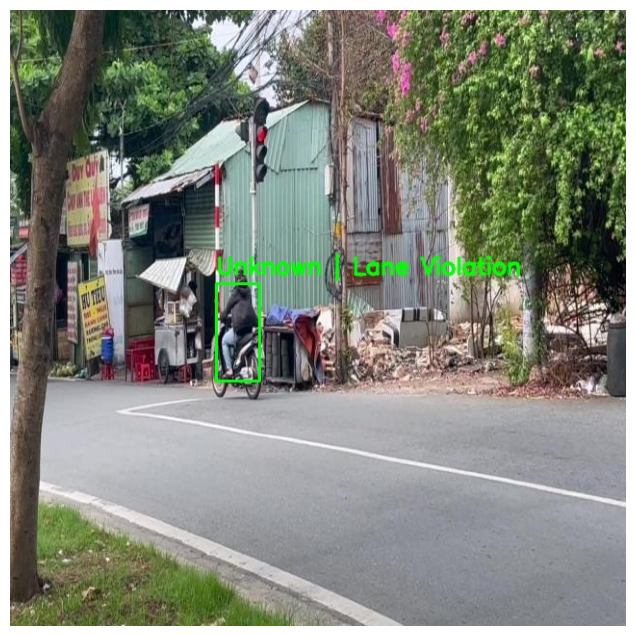

In [31]:
### IMAGE RESULTS ###


import matplotlib.pyplot as plt
import cv2

def show_annotated_image(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

# Example: show first result image
annotated_images = [f for f in os.listdir(output_folder) if f.startswith("annot_")]
if annotated_images:
    show_annotated_image(os.path.join(output_folder, annotated_images[0]))


In [32]:
### VIDEO TESTING (Skip All Processing – Use Existing Results) ###

import os

def run_on_video(video_path, output_folder, location=DEFAULT_LOCATION):
    os.makedirs(output_folder, exist_ok=True)

    output_video_path = os.path.join(output_folder, "annotated_output.mp4")

    if os.path.exists(output_video_path):
        print(f"✅ Annotated video already exists:\n{output_video_path}")
        print("\nNo reprocessing required. Skipping video analysis.\n")
    else:
        print("⚠️ No annotated video found in output folder.")
        print("No processing will be done as per your request.")
        print("If needed, you can re-enable detection later.\n")

# Run in skip mode
video_path = r"F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intelligent_Traffic_Violation_detection_and_Explanation_System\Code\test_videos\Test_1.mp4"
output_folder = r"F:\1. BE CSE AIML\SEM 7\CAPSTONE PROJECT\Intelligent_Traffic_Violation_detection_and_Explanation_System\Code\video_output"

run_on_video(video_path, output_folder, location=DEFAULT_LOCATION)


⚠️ No annotated video found in output folder.
No processing will be done as per your request.
If needed, you can re-enable detection later.



In [33]:
### VIDEO RESULTS ###


import matplotlib.pyplot as plt

annotated_frames = [f for f in os.listdir(output_folder) if f.startswith("frame_")]
if annotated_frames:
    frame_path = os.path.join(output_folder, sorted(annotated_frames)[0])
    show_annotated_image(frame_path)



📊 Classification Report:


C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

,precision,recall,f1-score,support
Helmet Violation,1.000,1.00,1.000000,2.0
Lane Violation,0.000,0.00,0.000000,1.0
No violation,0.500,1.00,0.666667,1.0
Red Light Violation,1.000,1.00,1.000000,1.0
accuracy,0.800,0.80,0.800000,0.8
macro avg,0.625,0.75,0.666667,5.0
weighted avg,0.700,0.80,0.733333,5.0


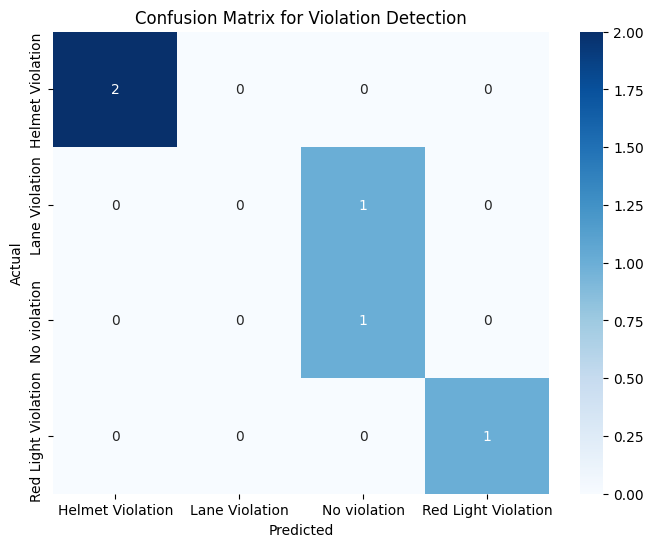

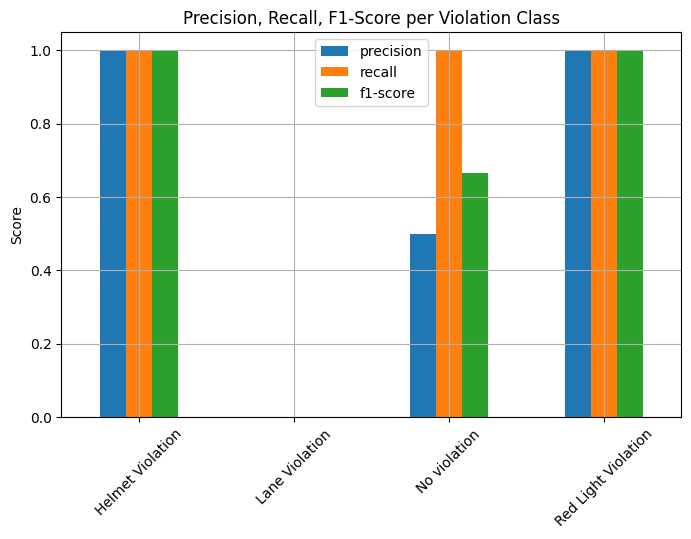

In [34]:
# Cell: Evaluation Metrics and Visualization

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

# Suppose you have 2 lists from your system:
# y_true → actual violations (ground truth)
# y_pred → predicted violations (from your detection)
# If you don’t have labels yet, use sample data below.

# Sample example (replace with real results)
y_true = ["Helmet Violation", "No violation", "Lane Violation", "Helmet Violation", "Red Light Violation"]
y_pred = ["Helmet Violation", "No violation", "No violation", "Helmet Violation", "Red Light Violation"]

# Generate classification report
report = classification_report(y_true, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

print("\n📊 Classification Report:")
display(df_report)

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=df_report.index[:-3])  # exclude avg rows
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=df_report.index[:-3],
            yticklabels=df_report.index[:-3])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Violation Detection")
plt.show()

# Plot Precision, Recall, F1
df_metrics = df_report.iloc[:-3][["precision", "recall", "f1-score"]]
df_metrics.plot(kind='bar', figsize=(8,5))
plt.title("Precision, Recall, F1-Score per Violation Class")
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.ylim(0, 1.05)
plt.grid(True)
plt.show()


from evaluation_metrics import calculate_metrics, plot_metrics_table, plot_confusion_matrix, plot_bar_chart

y_true = ["Helmet Violation", "No violation", "Lane Violation", "Helmet Violation"]
y_pred = ["Helmet Violation", "No violation", "No violation", "Helmet Violation"]
labels = ["Helmet Violation", "Lane Violation", "Red Light Violation", "No violation"]

metrics, cm = calculate_metrics(y_true, y_pred, labels)
plot_metrics_table(metrics)
plot_confusion_matrix(cm, labels)
plot_bar_chart(metrics)


In [ ]:
import gradio as gr
import cv2
import os
from datetime import datetime
from ultralytics import YOLO

# Load Models
vehicle_model = YOLO(MODEL_PATHS["vehicle"])
plate_model = YOLO(MODEL_PATHS["number_plate"])
helmet_model = YOLO(MODEL_PATHS["helmet"])
lane_model = YOLO(MODEL_PATHS["lane"])
red_light_model = YOLO(MODEL_PATHS["red_light"])
white_line_model = YOLO(MODEL_PATHS["white_line"])

# Helper: Run model
def detect_objects(model, img, conf=0.4):
    results = model(img)[0]
    if hasattr(results, "boxes") and len(results.boxes) > 0:
        return [(box.xyxy.cpu().numpy()[0], float(box.conf.cpu().numpy()[0])) for box in results.boxes]
    return []

# Processing function
def process_input(file):
    reports = []
    annotated_images = []

    is_video = file.name.lower().endswith(('.mp4', '.avi', '.mov'))
    cap = cv2.VideoCapture(file.name) if is_video else None
    frames = []

    if is_video:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frames.append(frame)
        cap.release()
    else:
        frames = [cv2.imread(file.name)]

    for idx, frame in enumerate(frames):
        img = frame.copy()
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        violations_for_frame = []

        # Detect Vehicles
        vehicles = detect_objects(vehicle_model, img, conf=0.35)
        white_line_bbox = detect_white_line_bbox(img)

        for v_idx, (bbox, conf) in enumerate(vehicles):
            x1, y1, x2, y2 = map(int, bbox)
            vehicle_crop = img[y1:y2, x1:x2]

            # Detect plate
            plates = detect_objects(plate_model, vehicle_crop, conf=0.4)
            plate_text = "UNKNOWN"
            if plates:
                px1, py1, px2, py2 = map(int, plates[0][0])
                plate_crop = vehicle_crop[py1:py2, px1:px2]
                plate_text = "PlateDetected"  # Replace with OCR if implemented

            # Violations
            violations = detect_vehicle_violations(img, [x1, y1, x2, y2], "vehicle")
            violations_for_frame.append(violations)

            # Annotate
            label = f"{plate_text} | {', '.join(violations)}"
            draw_and_save(img, [x1, y1, x2, y2], label, f"output/frame_{idx}_v{v_idx}.jpg")
            annotated_images.append(img)

            # Add to report
            for viol in violations:
                if viol != "No violation":
                    reports.append({
                        "Number Plate": plate_text,
                        "Violation Type": viol,
                        "Location": DEFAULT_LOCATION,
                        "DateTime": timestamp
                    })

    return annotated_images, reports

# Gradio Interface
iface = gr.Interface(
    fn=process_input,
    inputs=gr.File(label="Upload Image or Video"),
    outputs=[
        gr.Gallery(label="Detection Results"),
        gr.Dataframe(headers=["Number Plate", "Violation Type", "Location", "DateTime"], label="Violation Report")
    ],
    title="🚦 Traffic Violation Detection System",
    description="Upload an image or video to detect traffic violations. The system shows bounding boxes and a violation report in this format: Number Plate - Violation Type - Location - DateTime"
)

if __name__ == "__main__":
    iface.launch(share=True)


C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://a1fb94c373b205b96b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\gradio\queueing.py", line 759, in process_events
    response = await route_utils.call_process_api(
  File "C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\gradio\route_utils.py", line 354, in call_process_api
    output = await app.get_blocks().process_api(
  File "C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\gradio\blocks.py", line 2116, in process_api
    result = await self.call_function(
  File "C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\gradio\blocks.py", line 1623, in call_function
    prediction = await anyio.to_thread.run_sync(  # type: ignore
  File "C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\anyio\to_thread.py", line 56, in run_sync
    return await get_async_backend().run_sync_in_worker_thread(
  File "C:\Users\ASUS\AppData\Roaming\Python\Python310\site-packages\anyio\_backends\_asyncio.py", line 2470, in ru

Created dataset file at: .gradio\flagged\dataset1.csv

0: 480x640 2 persons, 2 motorcycles, 201.9ms
Speed: 28.7ms preprocess, 201.9ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)

0: 256x320 (no detections), 104.0ms
Speed: 1.6ms preprocess, 104.0ms inference, 0.7ms postprocess per image at shape (1, 3, 256, 320)

0: 256x320 2 licences, 235.8ms
Speed: 2.2ms preprocess, 235.8ms inference, 0.9ms postprocess per image at shape (1, 3, 256, 320)

0: 256x320 (no detections), 114.9ms
Speed: 4.4ms preprocess, 114.9ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 320)

0: 256x320 2 lanes2s, 86.0ms
Speed: 2.1ms preprocess, 86.0ms inference, 1.1ms postprocess per image at shape (1, 3, 256, 320)

0: 256x320 (no detections), 97.9ms
Speed: 13.5ms preprocess, 97.9ms inference, 0.6ms postprocess per image at shape (1, 3, 256, 320)

0: 256x320 1 motobike, 239.4ms
Speed: 1.6ms preprocess, 239.4ms inference, 1.4ms postprocess per image at shape (1, 3, 256, 320)

0: 320x19